In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
# setup disply parameters
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter

float_formatter = StrMethodFormatter("{x:0.03f}")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=(18, 6))  # set figure size
plt.rc("animation", html="html5")
import random

random.seed(0)
import numpy as np

np.random.seed(0)

In [2]:
from collections import defaultdict
import random
from negmas import SAOResponse
from scml.oneshot import *
from scml.oneshot.common import is_system_agent
from pprint import pprint


def try_agent(agent_type, n_processes=2, **kwargs):
    """Runs an agent in a world simulation against a randomly behaving agent"""
    return try_agents([RandomOneShotAgent, agent_type], n_processes, **kwargs)


def try_agents(
    agent_types, n_processes=2, n_trials=5, draw=True, agent_params=None, year=2024
):
    """
    Runs a simulation with the given agent_types, and n_processes n_trial times.
    Optionally also draws a graph showing what happened
    """
    type_scores = defaultdict(float)
    counts = defaultdict(int)
    agent_scores = dict()
    for _ in range(n_trials):
        p = (
            n_processes
            if isinstance(n_processes, int)
            else random.randint(*n_processes)
        )
        cls = {
            2022: SCML2022OneShotWorld,
            2023: SCML2023OneShotWorld,
            2024: SCML2024OneShotWorld,
        }[year]
        world = cls(
            **cls.generate(
                agent_types,
                agent_params=agent_params,
                n_steps=10,
                n_processes=p,
                random_agent_types=True,
            ),
            construct_graphs=True,
        )
        world.run()

        all_scores = world.scores()
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            key = aid if n_trials == 1 else f"{aid}@{world.id[:4]}"
            agent_scores[key] = (
                agent.type_name.split(":")[-1].split(".")[-1],
                all_scores[aid],
                "(bankrupt)" if world.is_bankrupt[aid] else "",
            )
        for aid, agent in world.agents.items():
            if is_system_agent(aid):
                continue
            type_ = agent.type_name.split(":")[-1].split(".")[-1]
            type_scores[type_] += all_scores[aid]
            counts[type_] += 1
    type_scores = {k: v / counts[k] if counts[k] else v for k, v in type_scores.items()}
    if draw:
        world.draw(
            what=["contracts-concluded"],
            steps=(0, world.n_steps - 1),
            together=True,
            ncols=1,
            figsize=(20, 20),
        )
        plt.show()

    return world, agent_scores, type_scores


def analyze_contracts(world):
    """
    Analyzes the contracts signed in the given world
    """
    import pandas as pd

    data = pd.DataFrame.from_records(world.saved_contracts)
    return data.groupby(["seller_name", "buyer_name"])[
        ["quantity", "unit_price"]
    ].mean()


def print_agent_scores(agent_scores):
    """
    Prints scores of individiual agent instances
    """
    for aid, (type_, score, bankrupt) in agent_scores.items():
        print(f"Agent {aid} of type {type_} has a final score of {score} {bankrupt}")


def print_type_scores(type_scores):
    """Prints scores of agent types"""
    pprint(sorted(tuple(type_scores.items()), key=lambda x: -x[1]))

## Developing an agent using RL (new in 2024)

The SCML game provides a new and interesting challenge for reinforcement learning and multi-agent reinforcement learning research. The main challenges in this game are:

1. Each world is different which means that a single policy is not likely to work effectively in all worlds. This means that it may be beneficial to train multiple RL agents and design a way to switch between them depending on the situation. This approach was shown to be effective in simple automated negotiations [before](https://arxiv.org/pdf/2102.03588).
2. The environment is partially observable because the agent has no access to the state of other agents. 
3. The environment is not deterministic because different penalties and exogenous contracts are sampled from probabilistic distributions and do affect the behavior of all agents in the environment.
4. The state space is huge. The information available to the agent through the `awi` despite being partial is still large enough that just passing everything to the RL training algorithm is not likely to work. 
5. Reward is sparce. No rewards of anykind are received - natively - during negotiations. The only rewards received by the agent are changes in its balance calculated at the end of every simulated day.

The SCML game is a realistic game for which any advance can readily be translated into a real-world application. Some of the best peforming agents in past iterations of SCML (OneShot) did use RL in some capacity. It was difficult to develop these agents because no native support was provided. In SCML 2024, we provide native support for developing RL agents both for the OneShot and Standard tracks. This tutorial walks you through the process involved in developing, training, and submitting a simple RL agent for SCML 2024 OneShot. The process is exactly the same for the standard track.

### Moving Pieces

RL support in SCML depends on multiple simple components. This section of the tutorial introduces all the moving pieces and describe how they fit together.  The overall design is shown in the following figure:

![SCML RL Components](rl.jpg)





#### The Context
One of the unique features of SCML compared with other RL games is the fact that every SCML simulation is different. For example, a market with two suppliers and a hundred consumers is pretty different from one with a hundred suppliers and two consumers. This makes it unlikely that a single RL agent can achieve high scores in *all* simulations. Agents that used machine learning in general and RL in particular in SCML 2019 to 2023 tended to train a dedicated model for each *set* of simulations that were judged to be similar enough for a single model to work well. We support this multi-model approach through the concept of a world **context**. A [Context](https://scml.readthedocs.io/en/latest/api/scml.oneshot.Context.html#scml.oneshot.Context) has two roles in SCML:

1. It can be used to **generate** worlds satisfying the constraint(s) defined by that context. For example, a [FixedPartnerNumberOneShotContext](https://scml.readthedocs.io/en/latest/api/scml.oneshot.FixedPartnerNumbersOneShotContext.html#fixedpartnernumbersoneshotcontext) will always generate oneshot worlds that have the specificed number of suppliers and consumers. This is done by calling the [generate](https://scml.readthedocs.io/en/latest/api/scml.oneshot.Context.html#scml.oneshot.Context.generate) method.
2. It can be used to **test** whether a given world/api/context satsifies the constraint(s) defined by the context. This is done by calling the [is_valid_world](https://scml.readthedocs.io/en/latest/api/scml.oneshot.Context.html#scml.oneshot.Context.is_valid_world)/[is_valid_awi](https://scml.readthedocs.io/en/latest/api/scml.oneshot.Context.html#scml.oneshot.Context.is_valid_awi)/[contains_context](https://scml.readthedocs.io/en/latest/api/scml.oneshot.Context.html#scml.oneshot.Context.contains_context) methods or simply using `in`. For example (`world in context`) will be `True` only if `world` could have been generated by `context`.



#### The Environment
As is always the case in RL, we need the following components: An **environment** which represents the game, an **agent** (or multiple agents) that that receive **observations** from the environment and return **actions** to it, and a **reward function** which provides feedback to the agent (during training). These directly translate to the components of the RL subsystem of SCML and the environment is what pulls all of this together.

[OneShotEnv](https://scml.readthedocs.io/en/latest/api/scml.oneshot.OneShotEnv.html#oneshotenv) is the base environment class. It instantiates `OneShotWorld`s based on the given `Context`. The agent is represented within this environment with a [Placeholder](https://scml.readthedocs.io/en/latest/api/scml.oneshot.Placeholder.html#oneshotdummyagent) which just acts as a placeholder for the RL agent interacting with this environment. You do not need to modify this placeholder agent or touch the environment (but you can if you wish to change how the interaction between it and the agent goes). The environment keeps track of the rest of the components as well and uses them to interact with the true `OneShotRLAgent` developed by the participant. These are the `RewardFunction`, `ObservactionManger` and `ActionManager` explained next.

<div class="alert alert-block alert-info">
    The environment is used <strong>offine</strong> during agent development for training and testing (See the left and middle panels above). In the official competition, worlds are generated directly and no environment is created (right panel above).
</div>

During training and testing of the RL model, the environment enacts the following process:

1. The context is used to generate a world in the beginning of the session and for generating new worlds once the current world simulation is done.
2. At every *step*, the environment uses the **ObservationManager** to **encode** the current state and pass it to the model being trained or tested.
3. The model generates actions which are **decoded** using the **ActionManager** as offers/counter offers in all negotiations in which the RL agent is involved. These offers are passed back to the world and the simulation is stepped.
4. At the end of every step, the **RewardFunction** is used to calculate the appropriate reward to be returned to the training algorithm during training.


#### Observation Manager

The observation manger is responsible of, well, managing ovbservation by implementing the following functionality: 

1. Creation of the appropriate [gymnasium observation space](https://gymnasium.farama.org/api/spaces/) to be used by the model representing the agent strategy. This is implemented by the [mak_space](https://scml.readthedocs.io/en/latest/api/scml.oneshot.ObservationManager.html#scml.oneshot.ObservationManager.make_space) method.
2. **Encoding** the current state of the environment as seen by the agent into an **observation** to be passed to the model. This observation must be compatible with the *action-space* created by this observation manager. This is implemented by the [encode](https://scml.readthedocs.io/en/latest/api/scml.oneshot.ObservationManager.html#scml.oneshot.ObservationManager.encode) method.

The observation manager can optionally implement a [get_offers](https://scml.readthedocs.io/en/latest/api/scml.oneshot.ObservationManager.html#scml.oneshot.ObservationManager.get_offers) method to extract partner offers from the encoded state. This functionality is not needed by RL agents but it may be helpful for debugging.

As explained in the previous section, the environment mainly uses the ObaservationManager() to encode the state of the world for the consumption of the RL agent. SCML's full observation of the agent (See [awi.state](https://scml.readthedocs.io/en/latest/api/scml.oneshot.OneShotState.html)) is extremely large. This means that the ability of the ObservationManager to balance keeping track of useful information and explosion of the state-space size will be an important factor in the success of RL agents in SCML. We suspect this component is where most of the designer effort needs to be spent.

#### Action Manager

The action manager is responsible of managing the actions flowing from the agent to environment. It must provide the following functionality:

1. Creation of the appropriate [gymnasium action space](https://gymnasium.farama.org/api/spaces/) to be used by the model representing the agent strategy. This is implemented by the [mak_space](https://scml.readthedocs.io/en/latest/api/scml.oneshot.ActionManager.html#scml.oneshot.ActionManager.make_space) method.
2. **Decoding** the action generated by the agent's model into a mapping of partners to counter-offers/responses. This is implemented by the [decode](https://scml.readthedocs.io/en/latest/api/scml.oneshot.ActionManager.html#scml.oneshot.ActionManager.decode) method

Optaionlly, the action manager can also implement *encoding* of any given response to partners into a model-compatible action in the [encode](https://scml.readthedocs.io/en/latest/api/scml.oneshot.ActionManager.html#scml.oneshot.ActionManager.encode) method. This is mostly used for debugging purposes.


#### Reward Function

During training, the environment needs to generate rewards for the RL policy being trained. This is the responsibility of the [RewardFunction](https://scml.readthedocs.io/en/latest/api/scml.oneshot.rl.RewardFunction.html). The default reward function simply returns the difference in agent's balance (money in the wallet) before and after executing its action. This is guaranteed to be zero as long as negotiations are going on and will only be nonzero at the end of every simulation day when profits are calculated by the simulator. You may consider designing a different reward function for your agent. The reward function is called twice in every step of the environment (i.e. every negotiation step):

1. The `before_action` method is called *before* the agent acts in the environment and is allowed to return arbitrary data.
2. The `__call__` method is called *after* the agent acts in the environment and it receives whatever data returned from `before_action`. This method is responsible of returning a real-valued reward to be passed to the agent.


#### The Agent

There are two RL-related agent types in SCML:

1. [OneShotRLAgent](https://scml.readthedocs.io/en/latest/api/scml.oneshot.OneShotRLAgent.html) is the main class responsible for implementing RL agents that can run in the OneShotWorld and compete in the scml-oneshot track.
1. [Placeholder](https://scml.readthedocs.io/en/latest/api/scml.oneshot.Placeholder.html#placeholder) which is used internally by the environment as a place-holder for the RL agent controlled by the `OneShotRLAgent`. You should not need to care about this agent type.

The `OneShotRLAgent` receives lists of models, observation and action managers and a fall-back agent type. During initialization ([init](https://scml.readthedocs.io/en/latest/reference/scml.html#scml.OneShotAgent.init) call), the agent loops through the observation and action managers checking whether the current world is compatible with them (i.e. in the contexts they are compatible with). Once such a match is found, the corresponding model is selected to act in this world simulation. You can have this test done only at initialization (default) or every step (see `dynamic_context_switching`) and you can use the given order of observation/action managers or randomize it every check. If no observation/action manager are found to be compatible with the current simulation, the `fallback_agent_type` is used to create a fall-back agent which takes over in interacting with the simulation.

You do not usually need to change anything about how this agent works but you can modify how it handles multiple contexts/models, use dynamic context switching, randomize model checking order, change the fall-back agent, etc.


##### Model

An `RLModel` is what you train for a given context. It takes the output of the ObservationManager as observations and generates actions for the ActionManager to pass into the simulation. You can write your own models by hand but, most likely, you will let an RL training algorithm train this model offline. You can then use the appropriate model for each world through the `OneShotAgent` explained above.

<div class="alert alert-block alert-info">
    You need to wrap trained models using wrap_model() before using them in OneShotRLAgent.
</div>

### How to train your dragon (agent)?

The process of developing your own RL agent for the scml competition is straight forward:

1. You need to decide what contexts will you be using. You can use any contexts in the scml package or design your own.
2. Create observation and action managers that are compatible with the contexts you decided (if ones are not already available in the scml package).
3. Train one model per context using the corresponding observation and action manager.
4. Test your models offline until you are satisfied of their performance.
5. Design a fallback agent that can be used whenever the world simulation does not match any of the contexts you designer/used.
6. Create a `OneShotRLAgent` (or `StdRLAgent` for the standard track) that simply loads the models you trained with their appropriate observation and action managers.
7. Submit your agent to the competition with the saved models.

### What can you change?

The moving parts that you control to develop your RL agent for SCML are the following:

1. **Context**. You can design your own contexts that represent the environments for which your models are trained. You can use as many contexts and train as many models as you need. We use one context for acting as a supplier and another for acting as a consumer in the [code template](https://yasserfarouk.github.io/files/scml/y2024/oneshot_rl.zip).
2. **RewardFunction**. You can design your own reward function and use it for training one or more of your models. You can use different reward functions for different contexts. We simply use the balance change at the end of the simulated day as the reward in the [code template](https://yasserfarouk.github.io/files/scml/y2024/oneshot_rl.zip).
3. **ObservationManager**. You can design what your agent observes in the environment. The default observation manager currently uses the following data from the AWI:

   - Received offers to be responded to
   - Needed sales and supplies
   - Number of production lines
   - Agent level (i.e. level 0 or 1)
   - Relative negotiation time (within the day)
   - Relative simulation time (day within the simulation)
   - disposal cost
   - shortfall penalty
   - current trading prices of input and output products
   
4. **ActionManager**. You can decide what kinds of actions does your agent generate and how can these be translated into negotiation actions during the competition. The default action manager can be used diretly to negotiate in any simulation.
5. **Training Algorithm**. You can change the training algorithm used for your models. You can even have different training algorithms for different models in different contexts. This is all done offline so you are completely free here. We use [A2C](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html) in the [code template](https://yasserfarouk.github.io/files/scml/y2024/oneshot_rl.zip).
6. **Model Architecture** You can design the neural architecture of your models in any way you like as long as it matches the training algorithm you are using and the observation/action manager they employ. We use a simple MLP architecture in the [code template](https://yasserfarouk.github.io/files/scml/y2024/oneshot_rl.zip).
5. **Fallback Strategy**. If a world does not match any of the contexts you designed, the system will use your fallback-strategy for the simulation represented by this world. You can modify the fallback strategy as well. The default fall-back agent is the [GreedyOneShotAgent](https://scml.readthedocs.io/en/latest/api/scml.oneshot.GreedyOneShotAgent.html)


### Developing an RL agent for SCML

In which we give a full example of developing an RL agent for SCML. You can use the [oneshot template](https://yasserfarouk.github.io/files/scml/y2024/oneshot_rl.zip) or the [std template](https://yasserfarouk.github.io/files/scml/y2024/std_rl.zip) provided by the organizers to simplify this process. The following example is roughly based on these templates.

The first step is to decide the contexts you are going to use for your RL agent. As explained above, an RL agent can use multiple models depending on the context it finds itself in. In this example we use two contexts, one for $L_0$ agents and another for $L_1$ agents.

#### Context Design
The function `make_context` below can be used to create either of these contexts:

In [3]:
N_SUPPLIERS = (1, 8)
N_CONSUMERS = (1, 8)


def make_context(as_supplier: bool):
    """Generates a context for the agent acting as a supplier or as a consumer"""
    n_agents_per_level = (
        min(N_SUPPLIERS[0], N_CONSUMERS[0]),  # type: ignore
        max(N_SUPPLIERS[1], N_CONSUMERS[1]),  # type: ignore
    )
    if as_supplier:
        return LimitedPartnerNumbersOneShotContext(
            n_suppliers=(0, 0),  # suppliers have no suppliers
            n_consumers=N_CONSUMERS,
            n_competitors=(N_SUPPLIERS[0] - 1, N_SUPPLIERS[1] - 1),
            n_agents_per_level=n_agents_per_level,
            level=0,  # suppliers are always in the first level
        )

    return LimitedPartnerNumbersOneShotContext(
        n_suppliers=N_SUPPLIERS,
        n_consumers=(0, 0),  # consumers have no consumers
        n_competitors=(N_CONSUMERS[0] - 1, N_CONSUMERS[1] - 1),
        n_agents_per_level=n_agents_per_level,
        level=-1,  # consumers are always in the last level
    )

#### Observation Manager Design

The second step, is to decide what observations are we going to get from the environment. This is the responsibility of the `ObservationManager`. Here we simply use one of the built-in observation managers.

<div class="alert alert-block alert-warning">
    The built-in observation manager is just a baseline that is not expected to behave well. Please be sure to design your own observation manager. You can use the code of the built-in observation manager as an example.
</div>

Our observation manager is implemented by `MyObservationManager` in which we show all the methods that you need to implement for your observation manager. 

In [4]:
from gymnasium import spaces


class MyObservationManager(LimitedPartnerNumbersObservationManager):
    """This is my observation manager implementing encoding and decoding the state used by the RL algorithm"""

    def make_space(self) -> spaces.Space:
        """Creates the observation space"""
        return super().make_space()

    def encode(self, state: OneShotState) -> np.ndarray:
        """Encodes an observation from the agent's state"""
        return super().encode(state)

    def make_first_observation(self, awi: OneShotAWI) -> np.ndarray:
        """Creates the initial observation (returned from gym's reset())"""
        return super().make_first_observation(awi)

    def get_offers(
        self, awi: OneShotAWI, encoded: np.ndarray
    ) -> dict[str, SAOResponse]:
        """Gets the offers from an encoded state"""
        return super().get_offers(awi, encoded)

#### Training

Now that we have a way to observe the environment, we can train two models for our two contexts. `train_models()` below achieves this by simply creating an environment for each context, instantiate an A2C trainer (from the stable_baselines3 library) and calls its `learn()` method to train the model. The two learned models are then returned.

In [5]:
from stable_baselines3 import A2C
from scml.oneshot.rl.action import UnconstrainedActionManager
from scml.oneshot.rl.agent import OneShotRLAgent
from scml.oneshot.rl.env import OneShotEnv


def train_models(type_="limited", n_training=100):
    # choose the type of the model. Possibilities supported are:
    # fixed: Supports a single world configuration
    # limited: Supports a limited range of world configuration
    # unlimited: Supports any range of world configurations

    def make_env(supplier, extra_checks: bool = False) -> OneShotEnv:
        context = make_context(supplier)
        return OneShotEnv(
            action_manager=UnconstrainedActionManager(context=context),
            observation_manager=MyObservationManager(
                context=context, extra_checks=extra_checks
            ),
            context=context,
            extra_checks=False,
        )

    models = []
    for as_supplier in (False, True):
        suffix = "supplier" if as_supplier else "consumer"
        print(f"Training as {suffix}")
        # create a gymnasium environment for training
        env = make_env(as_supplier, extra_checks=True)

        # choose a training algorithm
        model = A2C("MlpPolicy", env, verbose=0)

        # train the model
        model.learn(total_timesteps=n_training, progress_bar=True)
        print(f"\tFinished training the model for {n_training} steps")
        models.append(model)
    return models

We can now train our models

In [6]:
trained_models = train_models()

Training as consumer


Output()

	Finished training the model for 100 steps
Training as supplier


Output()

	Finished training the model for 100 steps


#### Creating the Agent

The final step is to create our agent class `MyAgent`. This class simply inherits from the `OneShotRLAgent` class and updates the initialization paratmers to use the models we just trained. Note that each model should be wrapped in a `Policy` object which is done by the `model_wrapper` method below. Also note that we use pass our observation manager to the base `OneShotRLAgent` alongside the model.

<div class="alert alert-block alert-info">
    It is possible to use different observation managers for differnt models. 
    <br>
    Make sure that the context used to train the model is the same as the one used for the observation manager.
</div>

In [7]:
from scml.oneshot.rl.common import model_wrapper


class MyAgent(OneShotRLAgent):
    """
    This is the only class you *need* to implement. The current skeleton simply loads a single model
    that is supposed to be saved in MODEL_PATH (train.py can be used to train such a model).
    """

    def __init__(self, *args, trainde_models=trained_models, **kwargs):
        # update keyword arguments
        kwargs.update(
            dict(
                # load models from MODEL_PATH
                models=tuple(model_wrapper(_) for _ in trained_models),
                # create corresponding observation managers
                observation_managers=(
                    MyObservationManager(context=make_context(True)),
                    MyObservationManager(context=make_context(False)),
                ),
            )
        )
        # Initialize the base OneShotRLAgent with model paths and observation managers.
        super().__init__(*args, **kwargs)

Now we can have an agent that can be tested as we did in the previous tutorial:

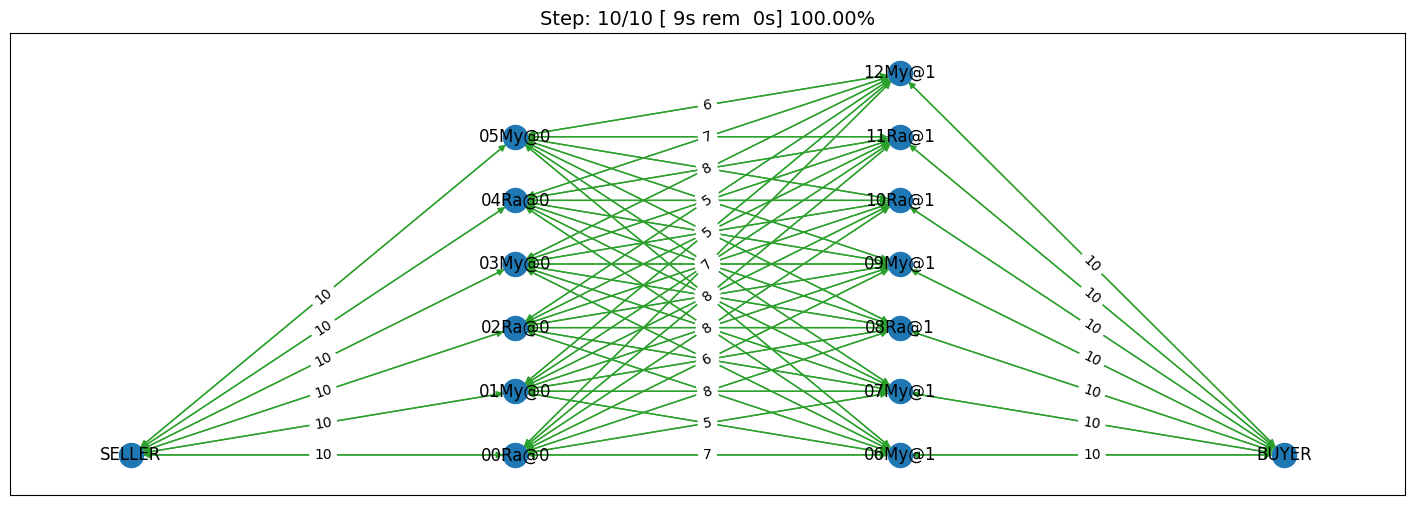

[('RandomOneShotAgent', 0.37318126997030443), ('MyAgent', 0.1645352458067952)]


In [10]:
world, ascores, tscores = try_agent(MyAgent)
print_type_scores(tscores)

#### What next?

As expected, the trained model is too weak for several reasons:

1. We trained it for only few steps (not even a complete world simulation). You will want to increase the number of steps during training.
2. The contexts we used are too general. A supplier with one other competitor and ten consumers is in a situation that is very different than one with ten other competitors and two consumers. You may need to think more carefully about what contexts makes sense for this problem.
3. The observation manager just does not make much sense. The built-in observation manager keeps track of the offers received and just few other parameters from the environment. This is not enough most likely to train a strong agent. Maybe, most of your time will be spent trying to come up with good observation managers.
4. The reward function received by the agent during training is simply the profit/loss accrued every day. This is too sparse as there is no signal during negotiations. You may consider doing reward shaping by creating a reward function and passing it to the environment used in training.


### A note about SCML Standard

This tutorial used the scml-oneshot simulation to show how to develop an RL agent. The same process works once you change every mention of OneShot with Std in the explanation above for the scml-std game. Be aware though that the standard track of SCML does not restrict the number of production levels to two as in the oneshot track. This means that the agent may find itself in the middle of the production graph negotiating on both sides for supplies and sales. This means that using two contexts one when we are in the first production level and another when we are in the last is not going to be enough for scml-std and we need at least a third context in which the agent is in the middle of the production graph.